In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-wisconsin-data/data.csv


In [23]:
df = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Data Visualization

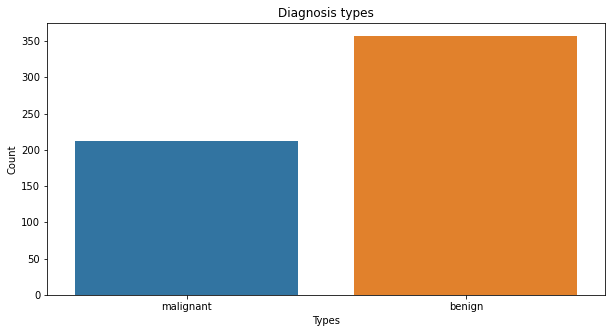

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))

sns.countplot(x=df['diagnosis'].map(lambda x : 'malignant' if x == 'M' else 'benign'))
plt.title('Diagnosis types')
plt.ylabel('Count')
plt.xlabel('Types')
plt.show()

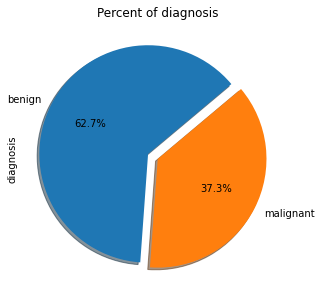

In [25]:
df['diagnosis'].map(lambda x : 'malignant' if x == 'M' else 'benign').value_counts()\
                                                                    .plot(kind='pie', explode = (0.1,0),figsize=(10,5),
                                                                            autopct='%1.1f%%', shadow=True, startangle=40)

plt.title('Percent of diagnosis')
plt.show()

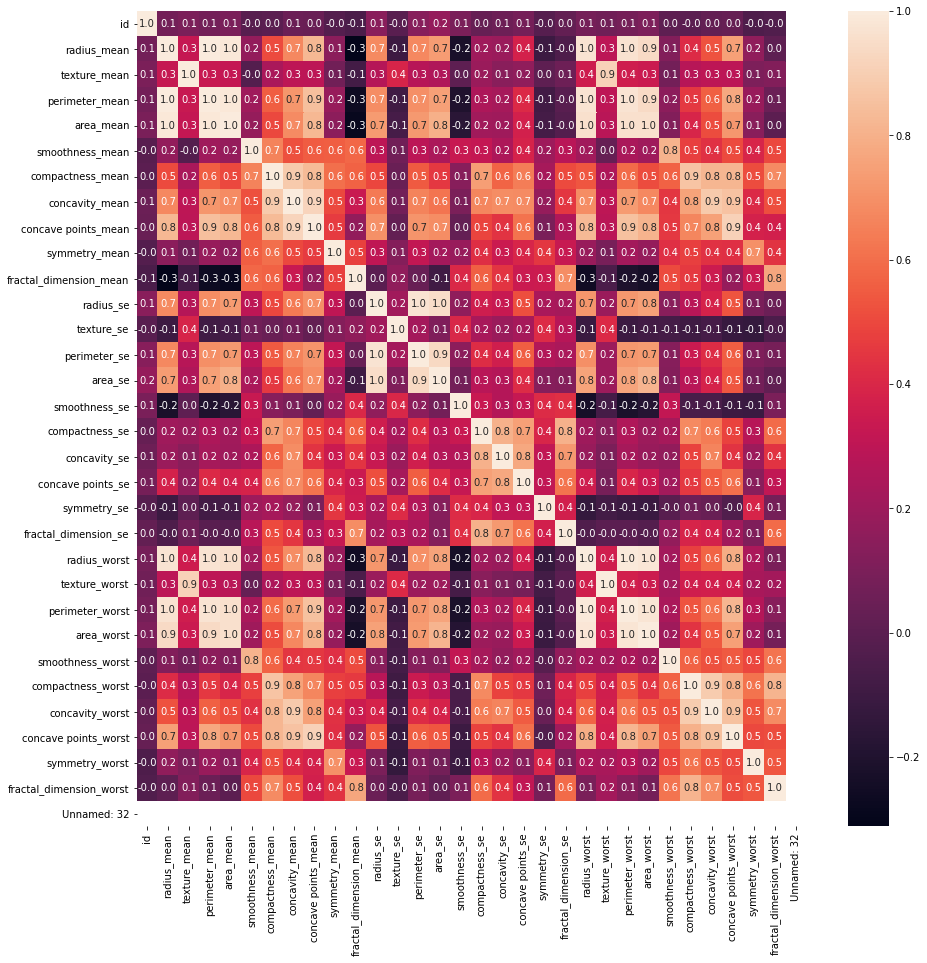

In [26]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, fmt='.1f')
plt.show()

## Data processing

In [27]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

for i in df.columns:
    if df[i].dtype == 'object':
        df[i] = label.fit_transform(df[i])

In [28]:
y = df['diagnosis']
X = df.drop(['id', 'diagnosis','Unnamed: 32'], axis=1)

## Split dataset

In [29]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2)

In [30]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, accuracy_score # for scoring during cross validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier()

In [32]:
preds = rf.predict(X_test)

accuracy_score(preds, y_test)

0.9649122807017544

## Tunning Hyperparameters

In [33]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [34]:
#Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100,
                               cv = 3,scoring = 'accuracy', verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='accuracy')

In [35]:
best_params = rf_random.best_params_
print(best_params)

{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}


In [36]:
best_rf =  RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)
best_rf_pred = best_rf.predict(X_test)

accuracy_score(best_rf_pred, y_test)

0.9649122807017544

In [ ]:
## Look most important parameters

## Look most important parameters

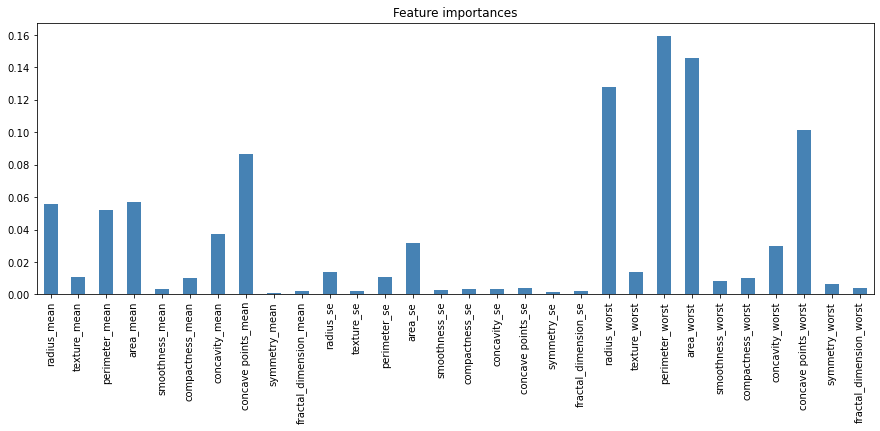

In [37]:
pd.Series(best_rf.feature_importances_, index=X.columns[:]).plot(kind='bar', color='steelblue', figsize=(15,5))
plt.title('Feature importances')
plt.show()